In [1]:
import re

import numpy
import pandas
import seaborn

from matplotlib import pyplot

from category_encoders import OrdinalEncoder

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

seaborn.set()

In [2]:
data = pandas.read_csv('laptops.csv', index_col=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303 entries, 1 to 1320
Data columns (total 12 columns):
Company             1303 non-null object
Product             1303 non-null object
TypeName            1303 non-null object
Inches              1303 non-null float64
ScreenResolution    1303 non-null object
Cpu                 1303 non-null object
Ram                 1303 non-null object
Memory              1303 non-null object
Gpu                 1303 non-null object
OpSys               1303 non-null object
Weight              1303 non-null object
Price_euros         1303 non-null float64
dtypes: float64(2), object(10)
memory usage: 132.3+ KB


In [3]:
data.head(10)

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60
6,Acer,Aspire 3,Notebook,15.6,1366x768,AMD A9-Series 9420 3GHz,4GB,500GB HDD,AMD Radeon R5,Windows 10,2.1kg,400.00
7,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.2GHz,16GB,256GB Flash Storage,Intel Iris Pro Graphics,Mac OS X,2.04kg,2139.97
8,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,256GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,1158.70
9,Asus,ZenBook UX430UN,Ultrabook,14.0,Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,16GB,512GB SSD,Nvidia GeForce MX150,Windows 10,1.3kg,1495.00
10,Acer,Swift 3,Ultrabook,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8GB,256GB SSD,Intel UHD Graphics 620,Windows 10,1.6kg,770.00


In [4]:
data['Screen'] = data['ScreenResolution'].map(lambda text: ' '.join(text.split(' ')[0:-1]))
data['Resolution'] = data['ScreenResolution'].map(lambda text: 
                                                  int(text.split(' ')[-1].split('x')[0]) *
                                                  int(text.split(' ')[-1].split('x')[1]))
data.drop('ScreenResolution', axis='columns', inplace=True)

In [5]:
data['Frequency'] = data['Cpu'].map(lambda text: float(text.split(' ')[-1][0:-3]))
data['CpuSeries'] = data['Cpu'].map(lambda text: ' '.join(text.split(' ')[0:-1]))
data.drop('Cpu', axis='columns', inplace=True)

In [6]:
data['Ram'] = data['Ram'].map(lambda ram: int(ram[0:-2]))

In [7]:
def parse_memory(memory):
    result = []
    memory = memory.replace('Flash Storage', 'SSD')
    memory = memory.replace('Hybrid', 'HDD')
    for match in re.finditer(r'(?P<number>\d+)(?P<unit>\w+) (?P<type>\w+)', memory):
        current = match.groupdict()
        current['number'] = int(current['number'])
        if current['unit'] == 'TB':
            current['number'] = current['number'] * 1024
            current['unit'] = 'GB'
        result.append((current['type'], current['number']))
    return result

data['Memory_HDD'] = 0
data['Memory_SSD'] = 0

for i, memory in data['Memory'].iteritems():
    for item in parse_memory(memory):
        data.at[i, 'Memory_' + item[0]] += item[1]
data.drop('Memory', axis='columns', inplace=True)

In [8]:
data['Weight'] = data['Weight'].map(lambda weight: float(weight[0:-2]))

In [9]:
X = data.drop('Price_euros', axis='columns')
y = data['Price_euros']

In [10]:
numeric_valued = (X.dtypes != object)
wide_range = (X.nunique() > 20)
numeric = numeric_valued & wide_range
categorial = ~wide_range

text_features = X.columns[~numeric_valued & wide_range]

print(text_features)
X.nunique()

Index(['Product', 'Gpu', 'Screen', 'CpuSeries'], dtype='object')


Company        19
Product       618
TypeName        6
Inches         18
Ram             9
Gpu           110
OpSys           9
Weight        171
Screen         21
Resolution     15
Frequency      25
CpuSeries      93
Memory_HDD      7
Memory_SSD     12
dtype: int64

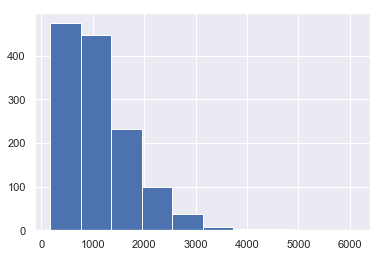

In [11]:
y.hist()

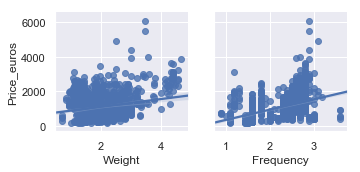

In [12]:
seaborn.pairplot(x_vars=X.columns[numeric], y_vars='Price_euros', data=data, kind='reg')

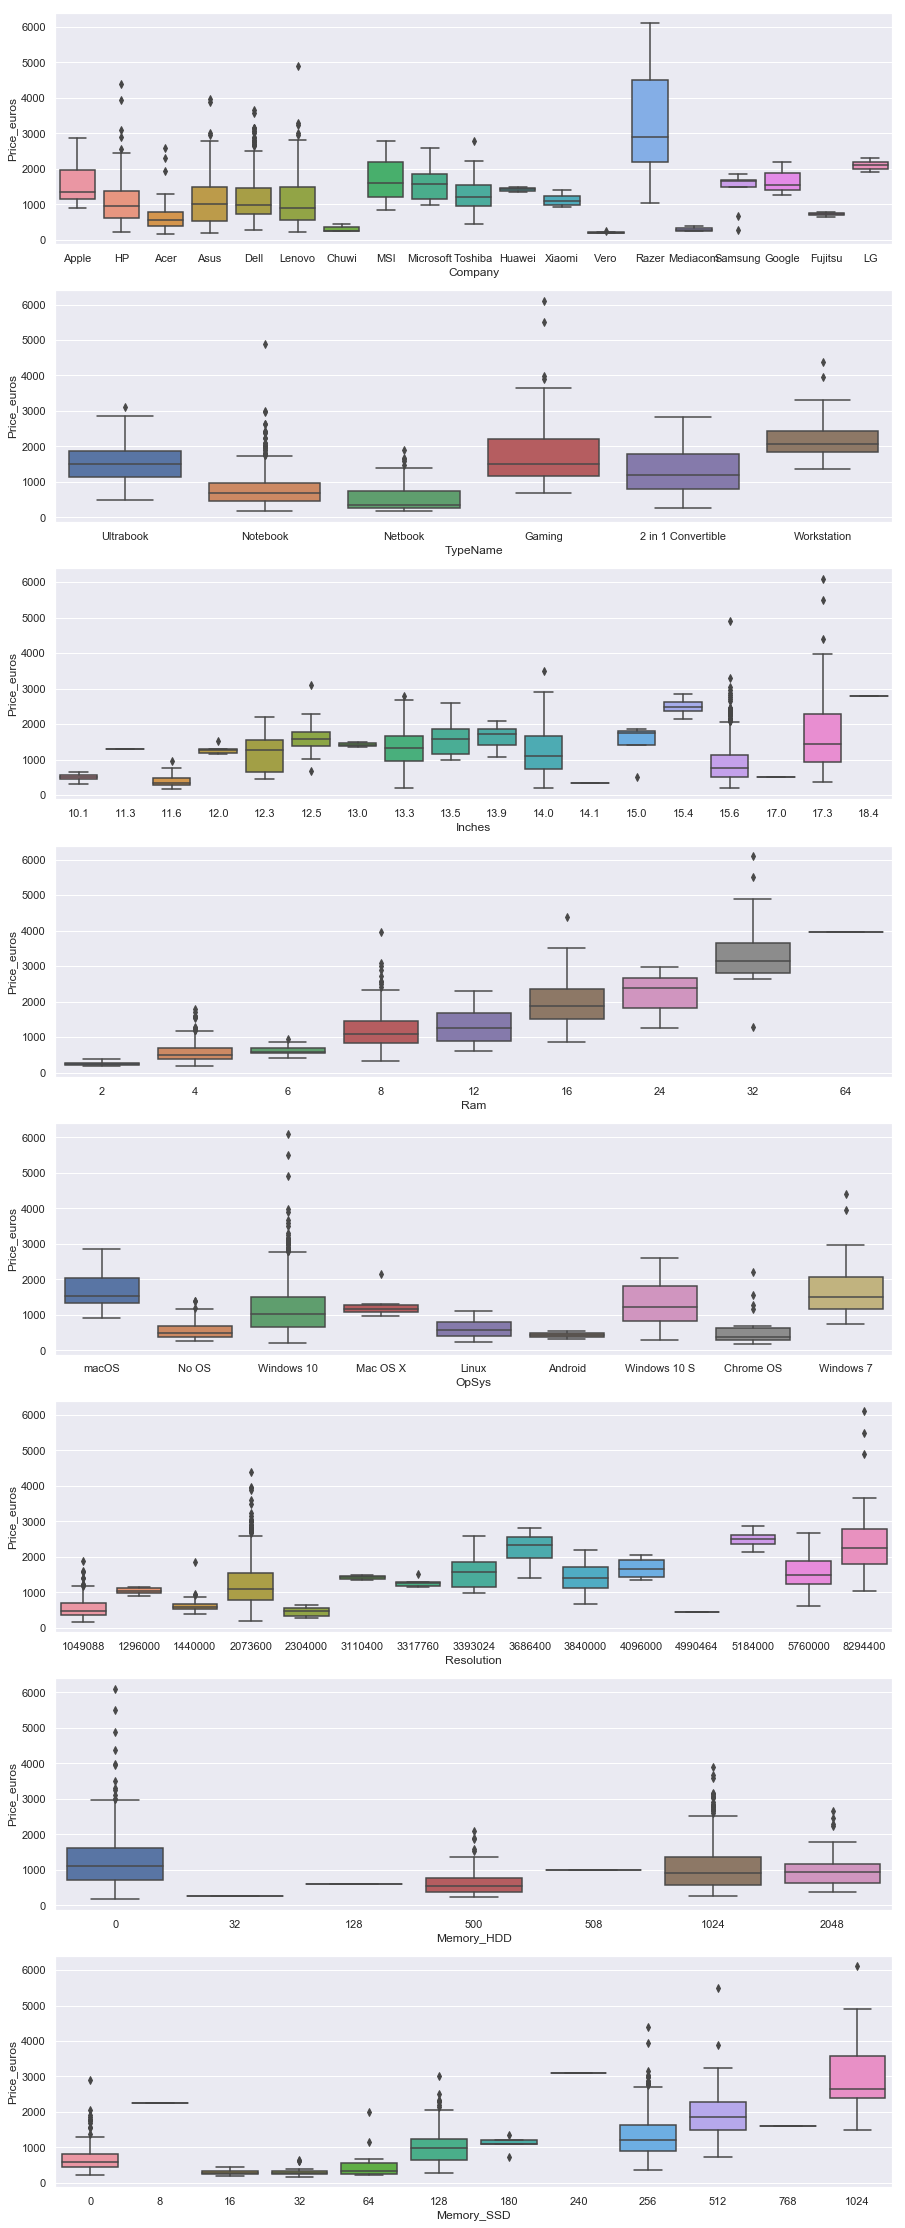

In [13]:
_, axes = pyplot.subplots(sum(categorial), figsize= (15, 5*sum(categorial)))
for ax, feature in zip(axes, X.columns[categorial]):
    seaborn.boxplot(x=feature, y='Price_euros', data=data, ax=ax)

In [14]:
seed = 5

explained_variance = {'CpuSeries': 0.7, 'Gpu': 0.8, 'Product': 0.6, 'Screen': 0.7}

preprocessor = ColumnTransformer([(feature+'_decomposer',
                                   Pipeline([('vectorizer', TfidfVectorizer()),
                                             ('to_dense', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
                                             ('pca', PCA(explained_variance[feature], random_state=seed))]),
                                   feature)
                                  for feature in text_features] +
                                 [('encoder', OrdinalEncoder(), ~numeric_valued & ~wide_range)],
                                 remainder='passthrough')

In [15]:
boosting_pipe = Pipeline([('prep', preprocessor), ('boosting', GradientBoostingRegressor(n_estimators=450, 
                                                                                         learning_rate=0.04,
                                                                                         min_samples_leaf=2,
                                                                                         random_state=seed))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

cv_losses = -cross_val_score(boosting_pipe, X_train, y_train, 
                             cv=KFold(10, True, seed), scoring='neg_mean_squared_error')

boosting_pipe.fit(X_train, y_train)
y_hat = boosting_pipe.predict(X_test)
holdout_loss = mean_squared_error(y_test, y_hat)

print('CV losses: {}\nMean: {}\nDeviation: {}\nHoldout loss: {}'.format(cv_losses.round(2), cv_losses.mean(), 
                                                                        cv_losses.std(), holdout_loss))

CV losses: [ 68088.76  62606.16  69684.16  38894.25  36510.36 114729.91  54548.63
  37201.56  53333.88  54896.29]
Mean: 59049.39531303108
Deviation: 21839.22477468841
Holdout loss: 43262.39909111873


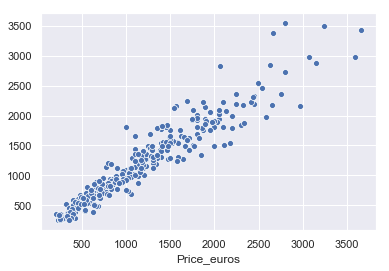

In [16]:
seaborn.scatterplot(y_test, y_hat)